# Applying the GP framework (Step 9 to 10)

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils import metrics
from utils import comparison_plot
import gpytorch
import torch
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader


## Step 9: Scaling

In [5]:
# Load data
train_df = pd.read_csv('data/training_set_tr.csv', index_col=[0])
val_df = pd.read_csv('data/validation_set_tr.csv', index_col=[0])
test_df = pd.read_csv('data/test_set_tr.csv', index_col=[0])

In [6]:
# Final kernel from step 8
kernel10 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=3, active_dims=[
                                  0, 1, 2]) + gpytorch.kernels.MaternKernel(nu=1.5, active_dims=[3]))

In [7]:
train_df

,elev,ocean_dist,slope,vel,aspect,x,y,dhdt_filt,date_max,date_min,group,dhdt_filt_tr,vel_log,slope_log
24264,-2.433803,-1.252527,9.341907,1012.658100,-0.974041,1.056095,-2.018737,-16.699478,737591.0,732021.0,245,-40.135260,3.194500,2.760699
24292,-2.418616,-1.248158,2.796925,2308.721200,-0.598086,1.055637,-2.017176,-15.987425,737591.0,732021.0,246,-38.412988,3.813394,1.742747
24318,-2.413647,-1.247086,2.856595,2457.125000,-0.456839,1.055614,-2.016838,-15.920738,737591.0,732021.0,247,-38.251691,3.860179,1.760565
24346,-2.377994,-1.242705,4.086462,2464.454000,-0.131946,1.056246,-2.015786,-15.047131,737591.0,732021.0,249,-36.138662,3.862416,2.062787
24233,-2.393782,-1.255647,17.748280,196.766200,-1.065170,1.056243,-2.019788,-14.524458,737591.0,732021.0,244,-34.874453,1.964155,3.302411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496442,-2.512338,-1.353392,0.644599,27.187147,0.527809,1.400054,1.452882,2.570973,737744.0,732478.0,1156,6.474936,0.477761,0.503935
496419,-2.517416,-1.346951,0.492721,34.634240,0.622544,1.400124,1.451258,2.585342,737591.0,732113.0,877,6.509693,0.659572,0.277143
496328,-2.490317,-1.322251,0.495429,49.693800,0.575360,1.411114,1.447688,2.592356,737744.0,732113.0,3140,6.526657,0.930704,0.281770
496400,-2.490835,-1.332677,0.396637,52.916306,0.666969,1.409575,1.449989,2.658297,737744.0,737379.0,1622,6.686152,0.977889,0.094044


In [8]:
# Sparse GP Model
class GPModel(ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
# Define input and output data
xtrain = train_df[['x', 'y', 'elev', 'ocean_dist']].values
ytrain = train_df['dhdt_filt'].values

xval = val_df[['x', 'y', 'elev', 'ocean_dist']].values 
yval = val_df['dhdt_filt'].values

In [10]:
# Make Pytorch dataloaders 
train_dataset = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

#test_dataset = TensorDataset(val_x, val_y)
#test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [11]:
# Define inducing points
idx = np.random.choice(len(xtrain), 1000, replace=False,)
inducing_points = torch.Tensor(xtrain[idx])

In [12]:
# Train model

num_epochs = 1
model = GPModel(inducing_points=inducing_points, kernel=kernel10)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(
    likelihood, model, num_data=len(ytrain))

epochs_iter = tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm(
        train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f ' % (i+1, num_epochs, loss.item()))

Epoch: 100%|██████████| 1/1 [00:37<00:00, 37.43s/it]

Iter 1/1 - Loss: 0.017 


### Check lengthscales

In [35]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')

Parameter name: variational_strategy.inducing_points       value = Parameter containing:
tensor([[-0.2861, -0.3996,  0.5631,  0.2196],
        [-1.0904, -1.3291,  0.7011,  1.4796],
        [ 1.3531,  0.0954,  0.4358, -0.0509],
        [ 1.1178,  1.3313, -1.0164, -1.2463],
        [-1.4664, -0.5276,  0.3238,  0.8473],
        [-0.0521,  0.3662,  0.0619, -0.5636],
        [ 1.1224, -1.0090,  1.0714,  0.9279],
        [ 0.4048,  2.1114, -2.6486, -2.1734],
        [-1.1136,  0.8522, -0.9611, -0.7423],
        [ 0.8483,  1.8233, -2.5628, -1.9904]], requires_grad=True)
Parameter name: variational_strategy._variational_distribution.variational_mean value = Parameter containing:
tensor([ 0.0906,  0.1696, -0.2330, -0.9145, -0.2812, -0.1286,  0.0955,  0.2065,
        -1.6992, -7.1225], requires_grad=True)
Parameter name: variational_strategy._variational_distribution.chol_variational_covar value = Parameter containing:
tensor([[ 1.7799e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
   

In [14]:
# Evaluate model

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(torch.Tensor(xval)))
    y_pred = preds.mean.numpy()
    y_var = preds.variance.numpy()

R2 = r2_score(yval, y_pred)
residuals = yval - y_pred
RMSE_mean = mean_squared_error(yval, y_pred, squared=False)
RMSE95 = metrics.RMSE95(yval, y_pred)
RMSE5 = metrics.RMSE5(yval, y_pred)
MLL = metrics.mll(yval, y_pred, y_var)

In [16]:
print('Mean RMSE = ', RMSE_mean)
print('Mean R2 = ', R2)
print('95th percent. RMSE = ', RMSE95)
print('5th percent. RMSE = ', RMSE5)
print('MLL= ', MLL)

Mean RMSE =  0.24574494386318274
Mean R2 =  0.6345976036915602
95th percent. RMSE =  0.36702122671608955
5th percent. RMSE =  0.8921886686820644
MLL=  -0.008104384352321343


## Step 10: Testing

### Metrics

In [18]:
xtest = test_df[['x', 'y', 'elev', 'ocean_dist']].values  # 'slope_log',
ytest = test_df['dhdt_filt'].values
xtest = torch.Tensor(xtest)

In [20]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(xtest))
    y_pred = preds.mean.numpy()
    y_var = preds.variance.numpy()

R2 = r2_score(ytest, y_pred)
residuals = ytest - y_pred
RMSE_mean = mean_squared_error(ytest, y_pred, squared=False)
RMSE95 = metrics.RMSE95(ytest, y_pred)
RMSE5 = metrics.RMSE5(ytest, y_pred)
MLL = metrics.mll(ytest, y_pred, y_var)

In [21]:
print('Mean RMSE = ', RMSE_mean)
print('Mean R2 = ', R2)
print('95th percent. RMSE = ', RMSE95)
print('5th percent. RMSE = ', RMSE5)
print('MLL= ', MLL)

Mean RMSE =  0.24604639946643495
Mean R2 =  0.6395511694506084
95th percent. RMSE =  0.3261749874451027
5th percent. RMSE =  0.9276279612754152
MLL=  -0.006030039630376629


## Plot

### Sparse GP on data subset

In [26]:
df_train = pd.read_csv('data/plot_train_data.csv')
df_train

,Unnamed: 0,elev,ocean_dist,slope,vel,aspect,x,y,dhdt_filt,phase_filt
0,0,1489.571300,92827.840462,0.582534,61.847473,172.486050,-49611.3300,-999748.25,-0.041159,-0.324275
1,1,1499.634900,92948.138853,1.007271,61.213276,302.729430,-48427.4900,-999830.60,-0.058663,-0.111330
2,2,1521.185800,92284.142570,0.849645,60.541233,298.642880,-46475.0820,-999898.40,-0.000959,0.222813
3,3,1548.180200,91215.018476,0.680605,60.723843,178.572360,-43934.1560,-999709.90,-0.043671,0.350641
4,4,1547.713900,91174.666845,0.688978,60.897408,168.096970,-43916.0660,-999673.50,-0.046723,0.332941
...,...,...,...,...,...,...,...,...,...,...
4217,4217,24.196693,-6447.059093,0.152172,123.499620,108.873184,-13203.2390,-900144.40,-0.427402,-0.520559
4218,4218,24.174225,-5856.040590,0.178501,136.365810,195.842960,-12417.9375,-900255.75,-0.348753,0.367094
4219,4219,25.731098,-504.250000,0.601238,5.173235,347.271450,-4923.2886,-900016.75,-0.023450,-0.525558
4220,4220,705.569640,12763.235352,2.160556,0.580673,217.612550,8915.7350,-900104.90,-0.011638,0.125541


In [27]:
scaler = StandardScaler().fit(
    df_train[['elev', 'ocean_dist', 'x', 'y']])
df_train[['elev', 'ocean_dist', 'x_tr', 'y_tr']] = scaler.transform(
    df_train[['elev', 'ocean_dist', 'x', 'y']])

In [28]:
xtrain = df_train[['x_tr', 'y_tr', 'elev', 'ocean_dist']].values  # 'slope_log',
ytrain = df_train['dhdt_filt'].values
train_dataset = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [30]:
n = 10 # number of inducing points
idx = np.random.choice(len(xtrain), n, replace=False,)
inducing_points = torch.Tensor(xtrain[idx])

In [31]:
# Train small model

num_epochs=150
model = GPModel(inducing_points=inducing_points, kernel=kernel10)
likelihood = gpytorch.likelihoods.GaussianLikelihood()


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(
    likelihood, model, num_data=len(ytrain))

epochs_iter = tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm(
        train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f ' % (i+1, num_epochs, loss.item()))

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Iter 1/150 - Loss: 1.512 


Epoch:   7%|▋         | 10/150 [00:00<00:08, 16.98it/s]

Iter 11/150 - Loss: 0.819 


Epoch:  13%|█▎        | 20/150 [00:01<00:07, 17.32it/s]

Iter 21/150 - Loss: 0.543 


Epoch:  20%|██        | 30/150 [00:01<00:07, 15.53it/s]

Iter 31/150 - Loss: 0.341 


Epoch:  27%|██▋       | 40/150 [00:02<00:06, 17.32it/s]

Iter 41/150 - Loss: 0.105 


Epoch:  33%|███▎      | 50/150 [00:02<00:05, 17.43it/s]

Iter 51/150 - Loss: -0.056 


Epoch:  40%|████      | 60/150 [00:03<00:05, 17.68it/s]

Iter 61/150 - Loss: 0.136 


Epoch:  47%|████▋     | 70/150 [00:04<00:04, 16.44it/s]

Iter 71/150 - Loss: -0.160 


Epoch:  53%|█████▎    | 80/150 [00:04<00:03, 18.18it/s]

Iter 81/150 - Loss: -0.414 


Epoch:  60%|██████    | 90/150 [00:05<00:03, 16.91it/s]

Iter 91/150 - Loss: -0.229 


Epoch:  67%|██████▋   | 100/150 [00:05<00:03, 15.69it/s]

Iter 101/150 - Loss: 0.056 


Epoch:  73%|███████▎  | 110/150 [00:06<00:02, 17.01it/s]

Iter 111/150 - Loss: -0.230 


Epoch:  80%|████████  | 120/150 [00:07<00:01, 18.49it/s]

Iter 121/150 - Loss: -0.483 


Epoch:  87%|████████▋ | 130/150 [00:07<00:01, 17.81it/s]

Iter 131/150 - Loss: -0.284 


Epoch:  93%|█████████▎| 140/150 [00:08<00:00, 16.83it/s]

Iter 141/150 - Loss: -0.472 


Epoch: 100%|██████████| 150/150 [00:08<00:00, 16.91it/s]


In [32]:
df_plot = pd.read_csv('data/plot_test_data.csv')
df_plot[['elev', 'ocean_dist', 'x_tr', 'y_tr']] = scaler.transform(df_plot[['elev', 'ocean_dist', 'x', 'y']])
xplot = df_plot[['x_tr', 'y_tr', 'elev', 'ocean_dist']].values
xplot = torch.Tensor(xplot)

In [33]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(xplot))
    y_pred = preds.mean.numpy()
    y_var = preds.variance.numpy()

df_plot['ypred'] = y_pred
#df_plot[['x', 'y', 'ypred']].to_csv('data/frame_output.csv')


### Comparison plot

Comparison plot with: \
    a = training data \
    b = k-NN \
    c = SE-ARD GP \
    d = original implementation \
    e = framework sparse GP \
    f = framework chunks

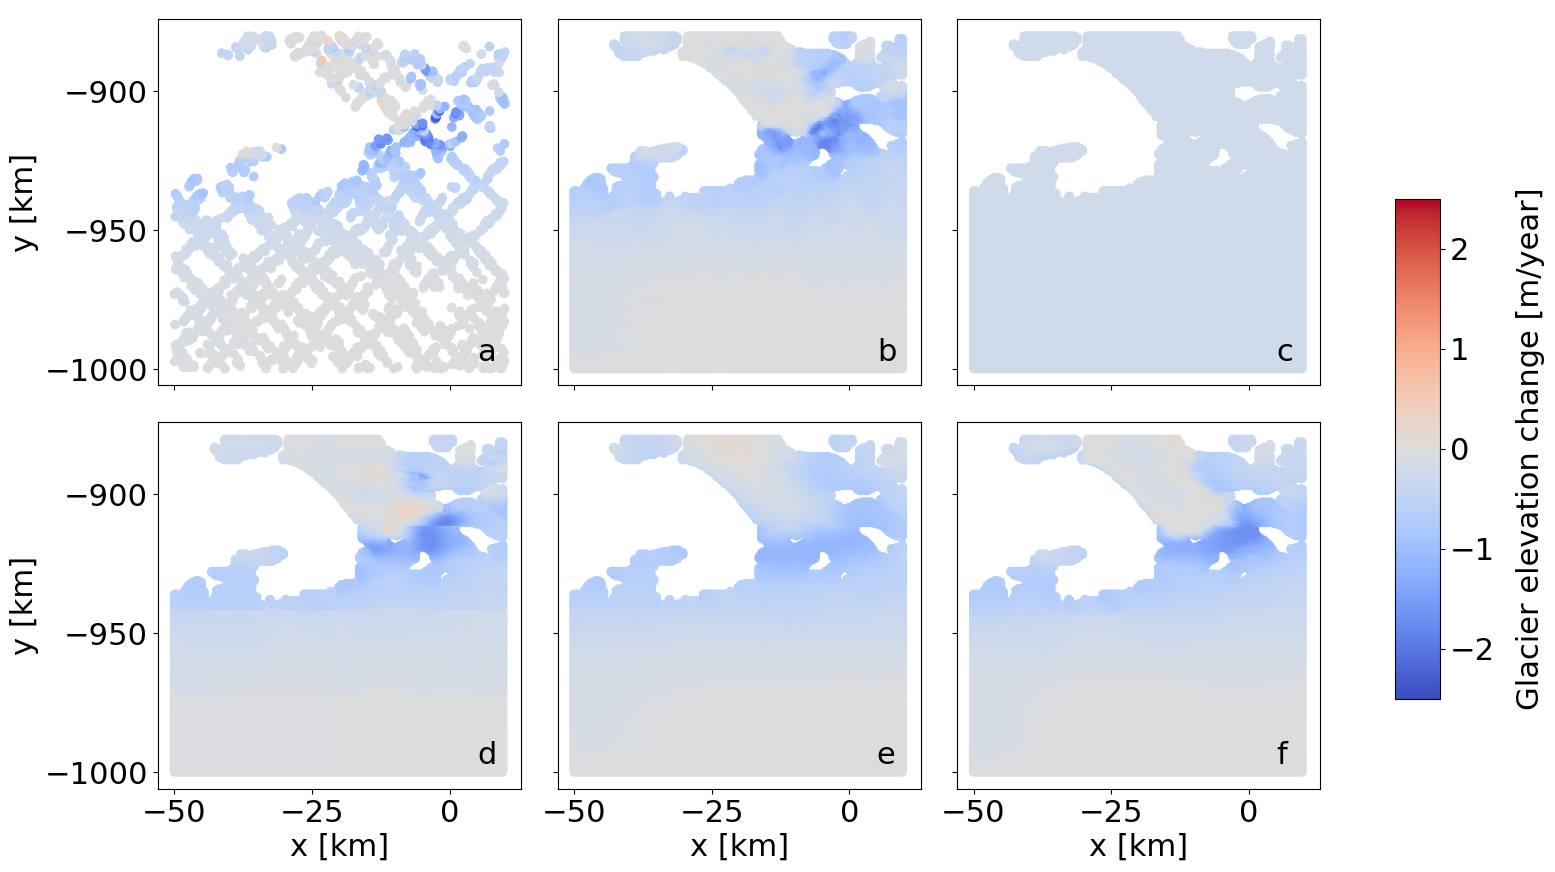

In [3]:
comparison_plot.plot()